# Module 3: Machine Learning

## Sprint 3: Introduction to Natural Language Processing and Computer Vision

## Kaggle competition - don't overfit!

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the competitions again!

## The competition

Even though we spent quite some time on natural language processing and computer vision during the sprint, the most accurate models on these types of data usually involves deep learning, that you will learn about in the upcoming course! In this project, the main goal will be to understand the concept of overfitting as deeply as possible, which essentially means fitting the training data very well at the expense of a model that generalizes and works well on other samples.

To learn about the concept of overfitting, we will participate in the following Kaggle competition:

- https://www.kaggle.com/c/dont-overfit-ii

IMPORTANT: download the data from here - https://www.kaggle.com/sahiltinky/org-dataset-dont-overfitii, as the evaluation is done on an older dataset version than the one available at the competition data section.

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now is to learn by first trying it yourself.

Some notebooks that are worth exploring:

- https://www.kaggle.com/artgor/how-to-not-overfit
- https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets

---

## Concepts to explore

- https://towardsdatascience.com/how-to-improve-your-kaggle-competition-leaderboard-ranking-bcd16643eddf
- https://opendatascience.com/10-tips-to-get-started-with-kaggle/

## Requirements

- Data exploration
- Feature engineering
- At least several different models built and compared to each other on the validation set and on the public and private leaderboards

## Evaluation criteria

- Private leaderboard score (target is better than 0.8)
- How simple is the model


## Sample correction questions

During a correction, you may get asked questions that test your understanding of covered topics.

- Is it possible to use standard machine learning algorithms, such as logistic regression and random forests, when working with text? If yes, what has to be done and how?
- You train a machine learning model and get a low validation accuracy. What other metrics you could check to better understand the problem? What are some of the ways to improve the validation accuracy?
- How does looking at the validation accuracy, confusion matrix and important features complement each other when evaluating the model's performance?
- How to make sure that the model that was deployed to production performs well?

# Project:

## Colab Setup

In [ ]:
# Additional libraries
!pip install eli5

In [ ]:
# Essential libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
RANDOM_STATE = 26

In [ ]:
# Modeling essentials
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
RobustScaler, PowerTransformer, MaxAbsScaler
from eli5.sklearn import PermutationImportance
import eli5

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import roc_auc_score

In [ ]:
# Train and test datasets
url_train = 'https://drive.google.com/file/d/1lAeNvz3ITC2mfczoonUPspyLp_Cnfm27/view?usp=sharing'
url_test = 'https://drive.google.com/file/d/1urb882HnXhd_9ULZUPD0qM8IdKHW8NfP/view?usp=sharing'

path_train = 'https://drive.google.com/uc?export=download&id='+url_train.split('/')[-2]
path_test = 'https://drive.google.com/uc?export=download&id='+url_test.split('/')[-2]

train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)
print("Data import successful!")

Data import successful!


### Functions

In [ ]:
def optimize_hyperparameters(x: pd.DataFrame, y: pd.Series,\
                             pipe: sklearn.pipeline.Pipeline, dist: dict) -> sklearn.base.BaseEstimator:
  """Runs a grid_search function to determine best hyperparameters.

  Parameters:
    x (pd.DataFrame): Training set on which to fit.
    y (pd.Series): Target set on which to fit.
    pipe (sklearn.pipeline.Pipeline): Pipeline on which to run optimization.
    dist (dict): Dictionary formatted as grid_search requires.

  Returns:
    grid search object (sklearn.base.BaseEstimator): Fitted onject with information which hyperparameters are best.
  """
  gs = GridSearchCV(
      pipe,
      dist,
      n_jobs=-1,
      verbose=0.5,
      scoring='roc_auc',
  )
  gs.fit(x, y)
  return gs

In [ ]:
def predict_scores(x_val: pd.DataFrame, y_val: pd.Series, x_train: pd.DataFrame,\
                   y_train: pd.Series, pipe: sklearn.pipeline.Pipeline,\
                   proba: bool = False) -> list:
  """Calculates AUCROC between predicted target and actual target.
  
  Parameters:
    x_val (pd.DataFrame): Validation set to predict target.
    y_val (pd.Series): Validation target to test predictions.
    x_train (pd.DataFrame): Training set to predict target.
    y_train (pd.Series): Training target to test predictions.
    pipe (sklearn.pipeline.Pipeline): Pipeline to use when predicting target.

  Returns:
    two value list (list): A list with training and validation score.
  """
  if proba:
    roc_train = roc_auc_score(y_train, pipe.predict_proba(x_train)[:,1])
    roc_valid = roc_auc_score(y_val, pipe.predict_proba(x_val)[:,1])
  else:
    roc_train = roc_auc_score(y_train, pipe.predict(x_train))
    roc_valid = roc_auc_score(y_val, pipe.predict(x_val))
  return np.round([roc_train, roc_valid], decimals=5)

In [ ]:
def create_test_file(pipe: sklearn.pipeline.Pipeline, x_test: pd.DataFrame, name: str,\
                     proba: bool = False) -> str:
  """Creates test file to submit to kaggle
  
  Parameters:
    pipe (sklearn.pipeline.Pipeline): Pipeline to use when predicting test target.
    x_test (pd.DataFrame): Test set to predict target.
    name (str): The name of submission file to create.

  Returns:
    a string that indicates that the file is created in the directory.
  """
  predictions = pd.DataFrame()
  if proba:
    predictions['target'] = pipe.predict_proba(x_test)[:,1]
  else:
    predictions['target'] = pipe.predict(x_test)
  predictions.index.name = 'id'
  predictions.index += 250
  predictions.to_csv(f"{name}.csv")
  return "File created"

##Pre-EDA

In [ ]:
train_df.head(2)

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.41,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.25,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.10,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.54,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973


In [ ]:
train_df = train_df.drop(columns=["id"]);
test_df = test_df.drop(columns=["id"]);

In [ ]:
train_df.shape

(250, 301)

In [ ]:
test_df.shape

(19750, 300)

After the first look at the data, I have noticed that the id column repeats so I decided to get rid of it.
Furthermore I checked how many features there are and how big the datasets are to decide how much data to use in validation split.  


##EDA

### Targets

In [ ]:
train_df['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

Target **0.0** has 90 occurrences and **1.0** has 160 making it the dominant target value composing 64% of the dataset.

### Missing values

In [ ]:
print("Missing value sum in training data: " + str(train_df.isnull().values.sum()))
print("Missing value sum in testing data: " + str(test_df.isnull().values.sum()))

Missing value sum in training data: 0
Missing value sum in testing data: 0


As we can see, there is no missing data in both of datasets. This eliminates the need of preproccessing (imputation).

### Distributions

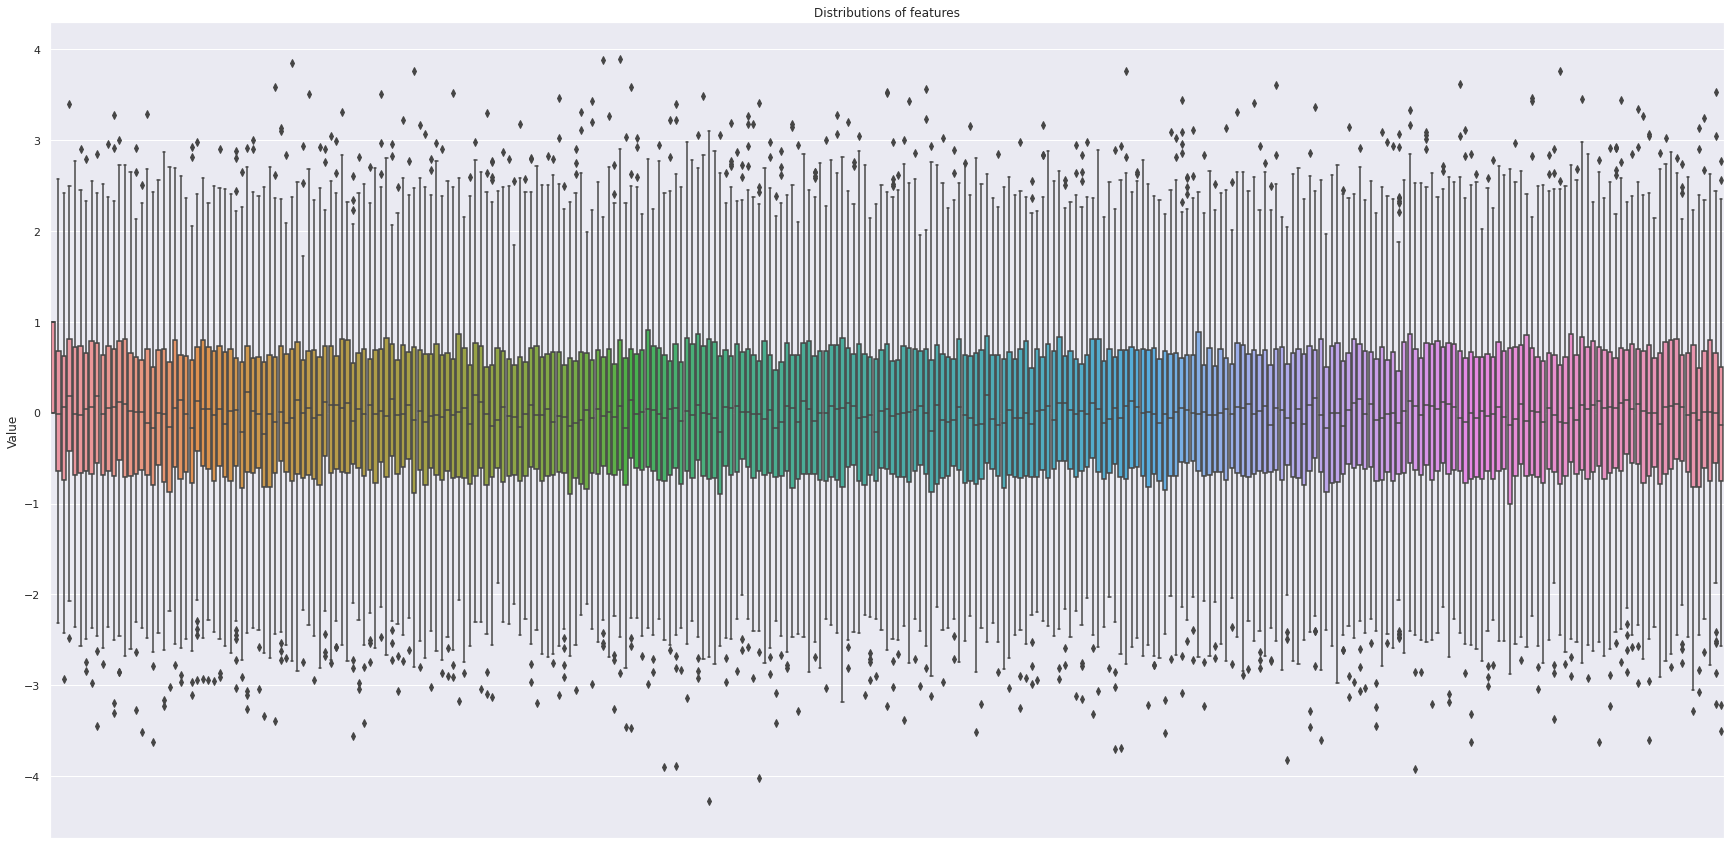

In [ ]:
sns.set(rc = {'figure.figsize':(30,15)})
ax = sns.boxplot(data=train_df)
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set_title("Distributions of features")
ax.set_ylabel("Value");

From the distribution above we can conclude that most of our data is in the same range from **4** to **-4**.  
I also tried to plot distributions based on target value but it didn't show any exceptional results.

### Mean / std / skewness / kurtosis

In [ ]:
numerical_features = pd.DataFrame(train_df.drop(columns='target'))

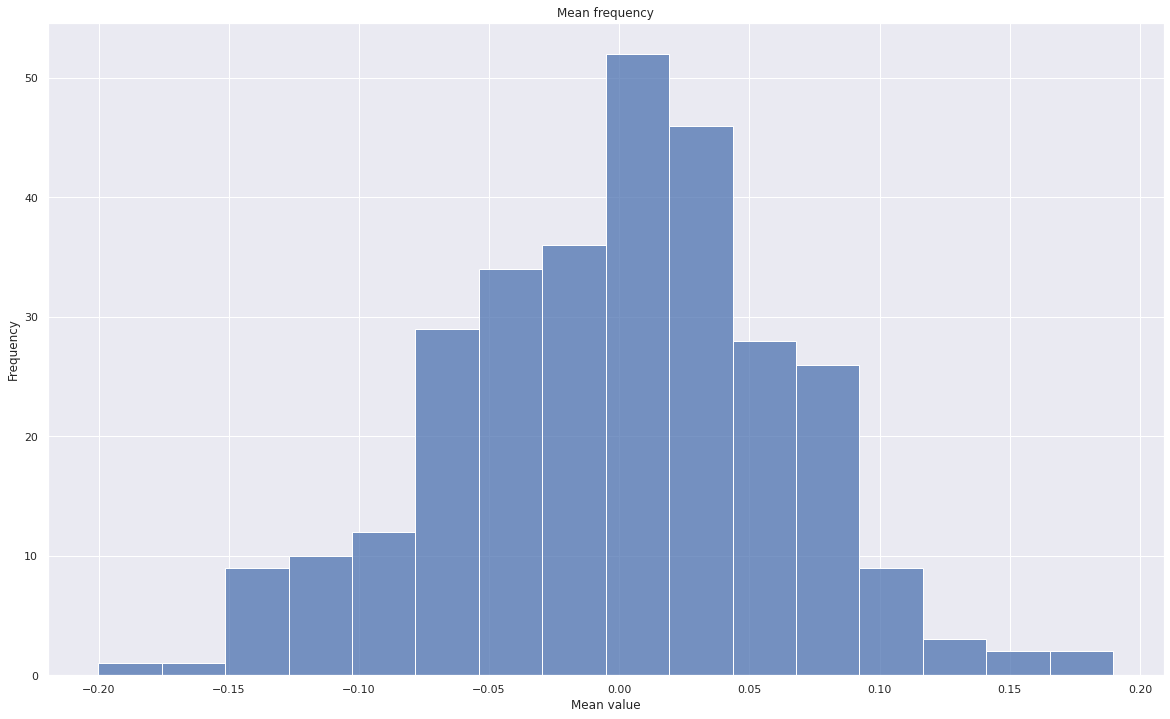

In [ ]:
sns.set(rc = {'figure.figsize':(20,12)})
ax = sns.histplot(data=numerical_features.mean())
ax.set_title("Mean frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Mean value");

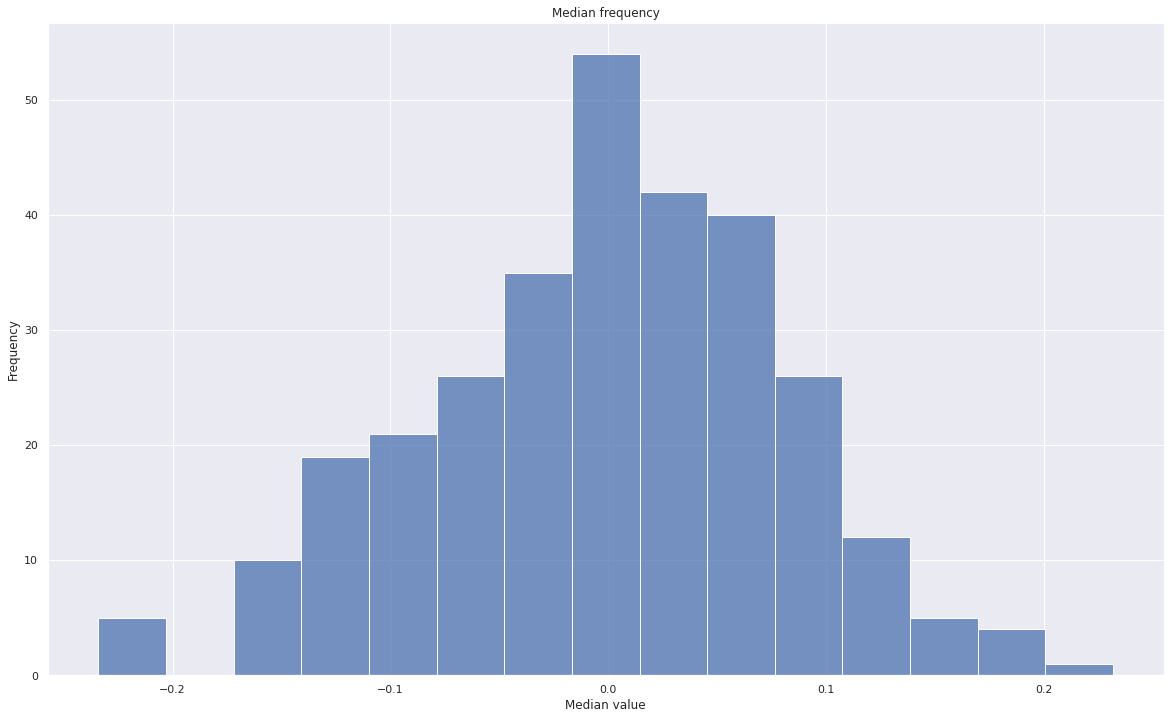

In [ ]:
ax = sns.histplot(data=numerical_features.median())
ax.set_title("Median frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Median value");

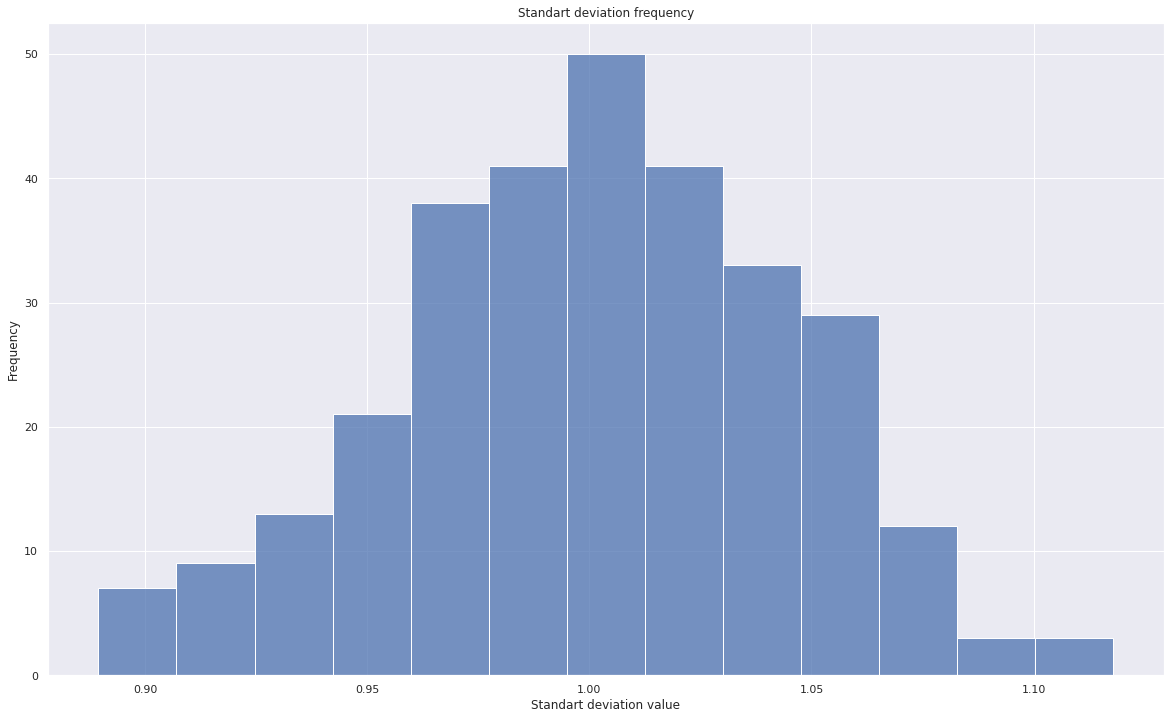

In [ ]:
ax = sns.histplot(data=numerical_features.std())
ax.set_title("Standart deviation frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Standart deviation value");

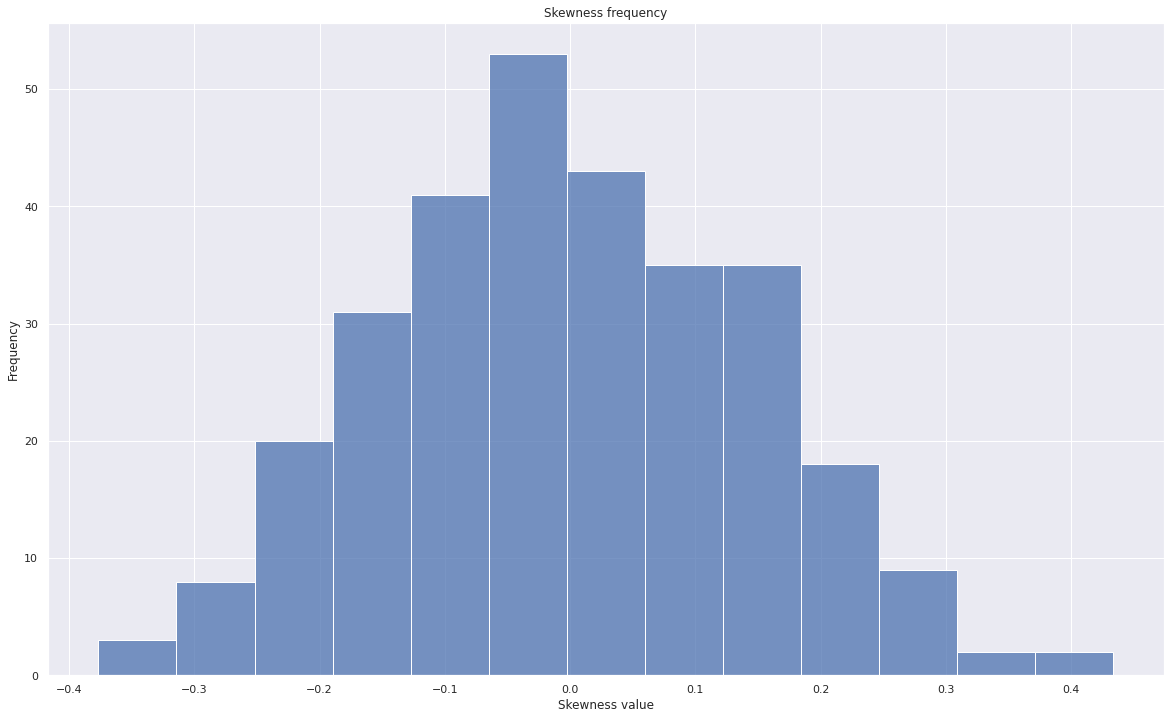

In [ ]:
ax = sns.histplot(data=numerical_features.skew())
ax.set_title("Skewness frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Skewness value");

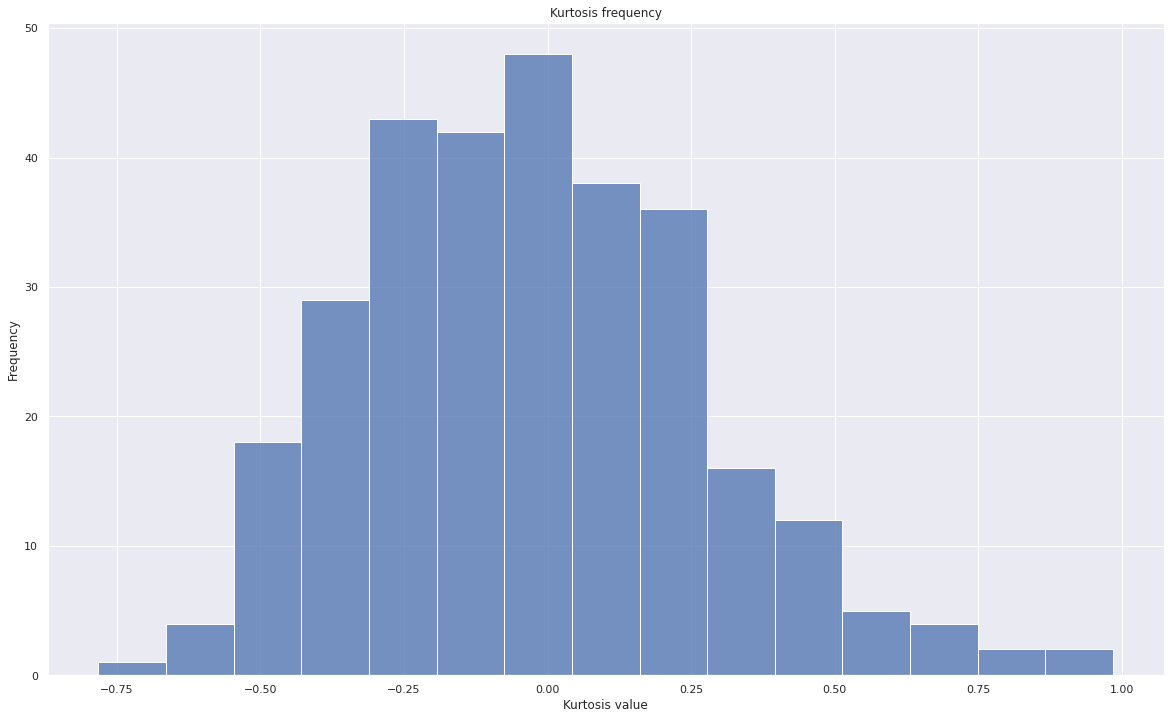

In [ ]:
ax = sns.histplot(data=numerical_features.kurt())
ax.set_title("Kurtosis frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Kurtosis value");

What we can see from these plots is that it seems that all features are standardized based on their mean and std values.   
Additionally after looking into the skewness (is data skewed to one or another side) and kurtosis (tailedness), the distribution seems to be similar to normal distribution.

### Correlation

In [ ]:
corr = train_df.corr()

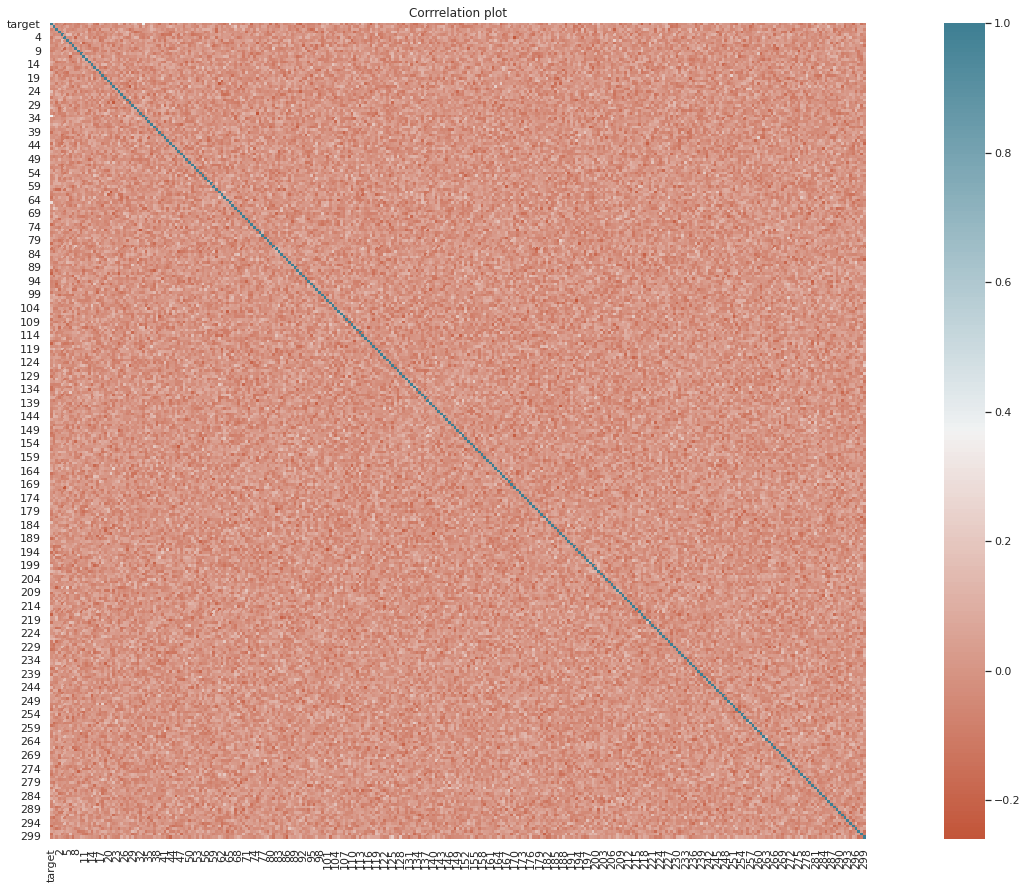

In [ ]:
sns.set(rc = {'figure.figsize':(28,15)})
ax = sns.heatmap(data=corr, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_title("Corrrelation plot");

We can see that there is no strong possitive or negative correlation.

### EDA conclusion

Although the target distribution is a little bit disbalanced, everything else from each feature distributions to mean, median, skewness, kurtosis distributions more or less follow normal distributions, or are similar to it.

There are no missing values indicating that we do not have to run feature imputation and can instantly jump to feature engineering, we could try to use scaler on features but I doubt it will cause any major changes in upcoming modeling sequence since it looks like these features are already scaled.

I cannot drive any conclusions from the correlation matrix since there are no strong possitive or negative correlations.

## Feature engineering

### Dataset preparation

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_df.drop(columns='target'), train_df['target'], test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
dsets = [train_x, valid_x, train_y, valid_y]
for idx, dset in enumerate(dsets):
  print(f"Dataset Nr. {idx+1}: " + str(dset.shape))

Dataset Nr. 1: (200, 300)
Dataset Nr. 2: (50, 300)
Dataset Nr. 3: (200,)
Dataset Nr. 4: (50,)


After splitting dataset into train and validation parts we are left with **200** rows of data in training set and **50** rows in validation set.

### Additional features

In [ ]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
  """Create additional features in a given dataset"""
  def __init__(self):
    self = self

  def fit(self, x: list, y: list = None):
    return self
  
  def transform(self, x: list, y: list = None) -> pd.DataFrame:
    x_ = pd.DataFrame(x.copy())
    for feature in x_:
      x_[f"{feature}_sq"] = np.square(x_[feature])
      x_[f"{feature}_sin"] = np.sin(x_[feature])
      x_[f"{feature}_cos"] = np.cos(x_[feature])
      x_[f"{feature}_tan"] = np.tan(x_[feature])
    return x_

In [ ]:
transformer = FeatureTransformer()
print("New dimensions of the data: " + str(transformer.transform(train_x).shape))

New dimensions of the data: (200, 1500)


Here I created and tested a new feature creation transformer that creates 4 new features for every column in the data.

In [ ]:
train_x_feat = transformer.transform(train_x)
valid_x_feat = transformer.transform(valid_x)

Creating the datasets with new features.

## Modeling

For the modeling part I have decided to try out 4 different clasification models

1.   Logistic Regression
2.   Naïve Bayes
3.   Support Vector Machine
4.   Random Forest



####Baseline without features

In [ ]:
log_reg_nf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg_nf.fit(train_x, train_y)

LogisticRegression(max_iter=1000, random_state=26)

In [ ]:
score = predict_scores(valid_x, valid_y, train_x, train_y, log_reg_nf)
print("Training score: " + str(score[0]) + "\nValidation score: " + str(score[1]))

Training score: 1.0
Validation score: 0.59113


Now we have a baseline to which we will be able to compare our future models.  
Let's try to add our feature transformer into the mix and see if new features actually are useful and provide a better score.

#### Baseline with features

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(train_x_feat, train_y)

LogisticRegression(max_iter=1000, random_state=26)

In [ ]:
score = predict_scores(valid_x_feat, valid_y, train_x_feat, train_y, log_reg)
print("Training score: " + str(score[0]) + "\nValidation score: " + str(score[1]))

Training score: 1.0
Validation score: 0.58292


We can see that the score that we got is slightly lower than model's without new features.

### Models starting performance

In [ ]:
gausian = GaussianNB()
svm = LinearSVC(max_iter=5000)
rf = RandomForestClassifier()
models = [gausian, svm, rf]

In [ ]:
for model in models:
  mod = model.fit(train_x_feat, train_y)
  score = predict_scores(valid_x_feat, valid_y, train_x_feat, train_y, mod)
  print(f"Features model: {model} " + "Training score: " + str(score[0]) + " Validation score: " + str(score[1]) + "\n")

Features model: GaussianNB() Training score: 0.96183 Validation score: 0.52463

Features model: LinearSVC(max_iter=5000) Training score: 1.0 Validation score: 0.61741

Features model: RandomForestClassifier() Training score: 1.0 Validation score: 0.5



In [ ]:
for model in models:
  mod_f = model.fit(train_x, train_y)
  score_f = predict_scores(valid_x, valid_y, train_x, train_y, mod_f)
  print(f"No features model: {model} " + "Training score: " + str(score_f[0]) + " Validation score: " + str(score_f[1]) + "\n")

No features model: GaussianNB() Training score: 0.99237 Validation score: 0.68637

No features model: LinearSVC(max_iter=5000) Training score: 1.0 Validation score: 0.57882

No features model: RandomForestClassifier() Training score: 1.0 Validation score: 0.5



All models have a perfect or nearly perfect score on the training data and low score on validation data. The score of 0.5 shows that model performs like a simple coin flip. We have two models that actually look like they are no better than a 50/50 chance.  
Such difference between training and validation scores shows that model fits perfectly to the training set, but is unable to generalize -> overfits.

Looking at the models that were trained on additional features, we can see that GaussianNB model actually gets a much better score on the validation data.

Let's look at the feature importances to see which features have the biggest weights on the models. 

### Feature imporantance

#### Logistic Regression

In [ ]:
perm = PermutationImportance(log_reg_nf, random_state=RANDOM_STATE).fit(valid_x, valid_y)

In [ ]:
eli5.show_weights(perm, feature_names=valid_x.columns.tolist())

Weight,Feature
0.0840 ± 0.0466,33
0.0680 ± 0.0650,65
0.0480 ± 0.0320,217
0.0400 ± 0.0000,262
0.0280 ± 0.0196,16
0.0280 ± 0.0408,73
0.0240 ± 0.0392,134
0.0240 ± 0.0299,80
0.0240 ± 0.0531,43
0.0200 ± 0.0000,213


We can see that there aren't many features that have a big overall impact to the Logistic Regression model, all features except first 4 have similar weights.

In [ ]:
perm_ft = PermutationImportance(log_reg, random_state=RANDOM_STATE).fit(valid_x_feat, valid_y)

In [ ]:
eli5.show_weights(perm_ft, feature_names=valid_x_feat.columns.tolist())

Weight,Feature
0.0440 ± 0.0160,246_tan
0.0360 ± 0.0160,77_tan
0.0240 ± 0.0160,11_tan
0.0240 ± 0.0160,285_tan
0.0200 ± 0.0000,64_tan
0.0200 ± 0.0000,50_tan
0.0200 ± 0.0000,199_tan
0.0200 ± 0.0000,210_tan
0.0200 ± 0.0000,123_tan
0.0200 ± 0.0253,78_tan


From the graph above we can see that newly created features have the biggest weights and dominate the model.

#### Naive Bayes

In [ ]:
gausian_model = GaussianNB().fit(train_x, train_y)
gausian_feat = GaussianNB().fit(train_x_feat, train_y)

In [ ]:
perm_g = PermutationImportance(gausian_model, random_state=RANDOM_STATE).fit(valid_x, valid_y)

In [ ]:
eli5.show_weights(perm_g, feature_names=valid_x.columns.tolist())

Weight,Feature
0.0360 ± 0.0392,33
0.0360 ± 0.0160,26
0.0360 ± 0.0160,76
0.0320 ± 0.0196,94
0.0280 ± 0.0543,73
0.0280 ± 0.0196,180
0.0280 ± 0.0320,211
0.0280 ± 0.0320,88
0.0240 ± 0.0160,205
0.0240 ± 0.0160,238


From what we get from this graph I could say that feature **33** takes 1-st place in both Logistic Regression and Naive Bayes models for having the biggest weight.

In [ ]:
perm_g_feat = PermutationImportance(gausian_feat, random_state=RANDOM_STATE).fit(valid_x_feat, valid_y)

In [ ]:
eli5.show_weights(perm_g_feat, feature_names=valid_x_feat.columns.tolist())

Weight,Feature
0.0280 ± 0.0196,181_tan
0.0240 ± 0.0160,139_tan
0.0240 ± 0.0299,46_tan
0.0200 ± 0.0000,180_tan
0.0200 ± 0.0253,294_tan
0.0200 ± 0.0253,119_tan
0.0200 ± 0.0253,220_tan
0.0160 ± 0.0299,74_tan
0.0120 ± 0.0196,231_tan
0.0120 ± 0.0196,183_tan


And we see the same trend again, new tangent values dominate model with features, except one squared feature with relatively small weight.

### Hyperparameters:

For hyperparameter tuning I have decided to use two models that did the best job of getting the best score before.  
(Logistic Regression and GausianNB)

####Logistic Regression

After running hyperparameter_optimizer and trying out different hyperparameters I have not noticed any improvements and most of the times the evaluation score would be worse than our logistic baseline.

#### Naive Bayes

After running hyperparameter_optimizer on GausianND model the score was much worse than before using new hyperparameters.

## Feature de-engineering

For the act of making the dataset smaller by picking specific features that impacted the model's score the most I choose to select max 50 features to be used for modeling.

#### Logistic Regression

In [ ]:
log_reg_nf_sel = SelectFromModel(perm, threshold=0.01, prefit=True, max_features=50)
train_x_l = log_reg_nf_sel.transform(train_x)

In [ ]:
train_x_l.shape

(200, 50)

In [ ]:
log_reg_sel = SelectFromModel(perm_ft, threshold=0.001, prefit=True, max_features=50)
train_x_l_feat = log_reg_sel.transform(train_x_feat)

In [ ]:
train_x_l_feat.shape

(200, 50)

Above I have created 2 different datasets to use only 50 most useful features for Logistic Regression with both, newly created features and old features datasets.

#### Naive Bayes

In [ ]:
gaussian_nf_sel = SelectFromModel(perm_g, threshold=0.02, prefit=True, max_features=50)
gaussian_train_x_l = gaussian_nf_sel.transform(train_x)

In [ ]:
gaussian_train_x_l.shape

(200, 50)

In [ ]:
gaussian_sel = SelectFromModel(perm_g_feat, threshold=0.02, prefit=True, max_features=50)
gaussian_train_x_l_feat = gaussian_sel.transform(train_x_feat)

In [ ]:
gaussian_train_x_l_feat.shape

(200, 11)

Above I have created 2 different datasets to use only 50 most useful features for GaussianNB with both, newly created features and old features datasets.

### Modeling 

#### Logistic Regression

In [ ]:
model_log_reg_sel = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE).fit(train_x_l, train_y)
model_log_reg_sel_feat = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE).fit(train_x_l_feat, train_y)

In [ ]:
score = predict_scores(log_reg_nf_sel.transform(valid_x), valid_y, train_x_l, train_y, model_log_reg_sel)
score1 = predict_scores(log_reg_sel.transform(valid_x_feat), valid_y, train_x_l_feat, train_y, model_log_reg_sel_feat)

In [ ]:
print("Logistic original dataset:\nTraining score: " + str(score[0]) + "\nValidation score: " + str(score[1]))
print("\nLogistic more features:\nTraining score: " + str(score1[0]) + "\nValidation score: " + str(score1[1]))

Logistic original dataset:
Training score: 0.90425
Validation score: 0.65846

Logistic more features:
Training score: 0.75855
Validation score: 0.59606


We can see that our feature selection decision helped the model to not overfit as much, we got a better score on both occasions (with and without new features) but the original dataset score change is much more noticeable (baseline score: 0.59) and now we got 0.65.

#### Naive Bayes

In [ ]:
model_gaussian_sel = GaussianNB().fit(gaussian_train_x_l, train_y)
model_gaussian_sel_feat = GaussianNB().fit(gaussian_train_x_l_feat, train_y)

In [ ]:
score = predict_scores(gaussian_nf_sel.transform(valid_x), valid_y, gaussian_train_x_l, train_y, model_gaussian_sel)
score1 = predict_scores(gaussian_sel.transform(valid_x_feat), valid_y, gaussian_train_x_l_feat, train_y, model_gaussian_sel_feat)

In [ ]:
print("Gaussian original dataset:\nTraining score: " + str(score[0]) + "\nValidation score: " + str(score[1]))
print("\nGaussian more features:\nTraining score: " + str(score1[0]) + "\nValidation score: " + str(score1[1]))

Gaussian original dataset:
Training score: 0.86763
Validation score: 0.53284

Gaussian more features:
Training score: 0.51599
Validation score: 0.60837


Unlike logistic regression, GaussianNB results got worse when given less features to work with.

## Choosing one model to explore

From the results we got earlier, since we strive for performance and simplicity, I have decided to use Logistic Regression for further research, thus it will allow me to dive deeper into data and experiment with it using different methods without needing to check on all models performance.

### Logistic Regression

In [ ]:
pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=25)),
                ('model', LogisticRegression(max_iter=1000,random_state=RANDOM_STATE)) 
                ])
pipe.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(),
                                 max_features=25, threshold=0.01)),
                ('model', LogisticRegression(max_iter=1000, random_state=26))])

In [ ]:
score = predict_scores(valid_x, valid_y, train_x, train_y, pipe)
print("Training score: " + str(score[0]) + "\nValidation score: " + str(score[1]))

Training score: 0.88633
Validation score: 0.70608


After playing with different number of features I have discovered that after scaling all the data and picking only 25 features actually improves the validation score and lowers the training score meaning that it overfits even less.

### Testing

In [ ]:
create_test_file(pipe, test_df, "log_pipe_0.70_test")

'File created'

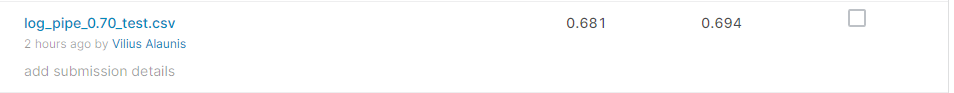

It is an amazing result, although I didn't show previous results from the test data, they were much worse averaging about 0.55 so this score really brightens my day, also let's try to use the predict_proba function on the model since it's been reported to achieve better results.

In [ ]:
score = predict_scores(valid_x, valid_y, train_x, train_y, pipe, proba=True)
print("Training score: " + str(score[0]) + "\nValidation score: " + str(score[1]))

Training score: 0.97455
Validation score: 0.77668


Using the predict_proba function whihc returns probabilities of each clasification decision we can see that the validation score got much higher. Let's try this on the test data and compare results.

In [ ]:
create_test_file(pipe, test_df, "log_pipe_proba_0.70_test", proba=True)

'File created'

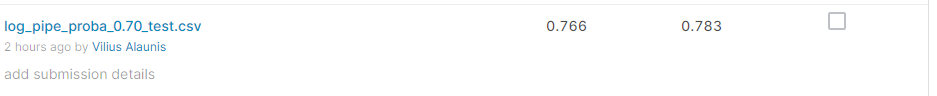

Woah! Using probability of target **1** increases the public score by almost 0.1 which is huge.

### Training on the whole dataset

In [ ]:
pipe_full = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=25)),
                ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)) 
                ])
pipe_full.fit(train_df.drop(columns='target'), train_df['target'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(),
                                 max_features=25, threshold=0.01)),
                ('model', LogisticRegression(max_iter=1000, random_state=26))])

In [ ]:
create_test_file(pipe_full, test_df, "log_pipe_proba_test_25", proba=True)

'File created'

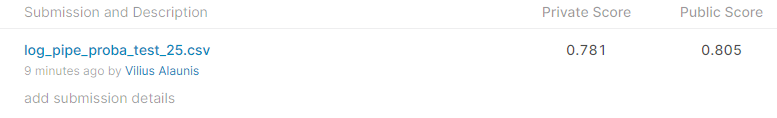

As we can see, model needs more corrections to achieve the required private leaderboard score. Let's try to tweak the number of features given to the model.

In [ ]:
pipe_full = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=26)),
                ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)) 
                ])
pipe_full.fit(train_df.drop(columns='target'), train_df['target'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(),
                                 max_features=26, threshold=0.01)),
                ('model', LogisticRegression(max_iter=1000, random_state=26))])

In [ ]:
create_test_file(pipe_full, test_df, "log_pipe_proba_test_26", proba=True)

'File created'

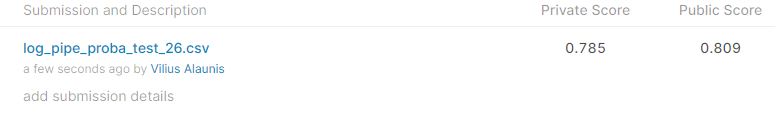

As we can see making the feature count bigger improved the score, but continuing in doing so showed decrease in competition score.  
From before, I have noticed that the kaggle score is lower by 0.02 compared to my own validation score, so to get a satisfactory private score of I would need to theoretically get 0.82 as my validation score.

### Testing scalers

In [ ]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), MaxAbsScaler()]

In [ ]:
for scaler in scalers:
  pipe_scaler = Pipeline([
                  ('scaler', scaler),
                  ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=26)),
                  ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)) 
                  ])
  pipe_scaler.fit(train_x, train_y)
  score = predict_scores(valid_x, valid_y, train_x, train_y, pipe_scaler, proba=True)
  print(f"\n{scaler}:\nTraining score: " + str(score[0]) + "\nValidation score: " + str(score[1]))


StandardScaler():
Training score: 0.98141
Validation score: 0.78161

MinMaxScaler():
Training score: 0.96958
Validation score: 0.75205

RobustScaler():
Training score: 0.97511
Validation score: 0.74713

PowerTransformer():
Training score: 0.9823
Validation score: 0.79475

MaxAbsScaler():
Training score: 0.97312
Validation score: 0.72085


We can see that PowerTransformer() actually provides a better validation score. But after testing the new pipeline on kaggle it failed to provide better results.  
Let's look into hyperparameters of Logistic Regression next.

### Hyperparameters

In [ ]:
pipe_hp = Pipeline([
                  ('scaler', StandardScaler()),
                  ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=26)),
                  ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)) 
                  ])
dist = dict(
    model__solver=['saga', 'liblinear'],
    model__C=[0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0],
    model__penalty=['l1']
)
log_hp = optimize_hyperparameters(train_x, train_y, pipe_hp, dist)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [ ]:
log_hp.best_params_

{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

Let's use these hyperparameters and test results on kaggle.

#### Testing hyperparameters

In [ ]:
pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectFromModel(LogisticRegression(), threshold=0.01, max_features=26)),
                ('model', LogisticRegression(max_iter=1000, solver='liblinear',\
                                              penalty='l1',\
                                              C=0.1,\
                                              random_state=RANDOM_STATE)) 
                ])
pipe.fit(train_x, train_y)

In [ ]:
score = predict_scores(valid_x, valid_y, train_x, train_y, pipe, proba=True)
print("Standard Scaler:\nTraining score: " + str(score[0]) + "\nValidation score: " + str(score[1]))

Standard Scaler:
Training score: 0.93771
Validation score: 0.80624


The validation score is better than before, this is good news, now let's try to submit it to kaggle.

### Test results

In [ ]:
create_test_file(pipe, test_df, "log_scaled_hp", proba=True)

'File created'

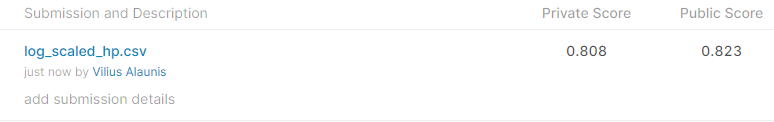

Hyperparameters helped to increase our private leaderboard score and finally we got the >0.8 score.